In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy
from scipy.io import arff, loadmat

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split
from nltk.classify.naivebayes import NaiveBayesClassifier


sys.path.append('../third_party')
sys.path.append('../methods')

## Data generation

In [24]:
from utils_data import DataSet

base_path = "/media/msesia/Samsung/data/"

random_state = 2021
model = DataSet(base_path, "images_flowers", random_state=random_state, prop_mix=0.5)
n_in = 10000
n_out = 10

X, Y = model.sample(n_in=n_in, n_out=n_out, mislabeled_prop=0)
X_test, Y_test = model.sample_test(n=100)

print("Number of features: {}.".format(X.shape[1]))
print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Loaded data set with 3670 samples: 641 inliers and 3029 outliers, of which 0 are available for training.
Number of features: 512.
Number of inliers in training/calibration data: 513.
Number of outliers in training/calibration data: 10.
Number of inliers in test data: 54.
Number of outliers in test data: 46.


## Conformal p-values via one-class classification (split)

Fitting the black-box model on 256 data points... done.
Calculating conformity scores for 257 hold-out data points... done.
Calculating conformity scores for 100 test points... done.


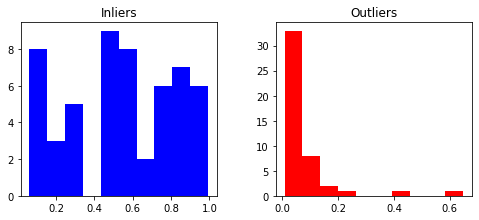

0.046511627906976744

In [29]:
from methods_split import OneClassConformal as OneClassConformal_split

# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [#svm.OneClassSVM(kernel='linear'),
                 svm.OneClassSVM(kernel='rbf'),
                 svm.OneClassSVM(kernel='sigmoid'),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = "auto", random_state=random_state),
                 #IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40),
                 LocalOutlierFactor(contamination='auto', novelty=True),
                 SGDOneClassSVM(random_state=random_state)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[-1]

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal_split(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
#axs[0].set_xlim(0,1)
#axs[1].set_xlim(0,1)
plt.show()

np.median(pvals_oneclass[Y_test==1])

## Conformal p-values via one-class classification

Fitting the black-box model 0 on 461 inliers... done.
Fitting the black-box model 1 on 461 inliers... done.
Fitting the black-box model 2 on 461 inliers... done.
Fitting the black-box model 3 on 462 inliers... done.
Fitting the black-box model 4 on 462 inliers... done.
Fitting the black-box model 5 on 462 inliers... done.
Fitting the black-box model 6 on 462 inliers... done.
Fitting the black-box model 7 on 462 inliers... done.
Fitting the black-box model 8 on 462 inliers... done.
Fitting the black-box model 9 on 462 inliers... done.


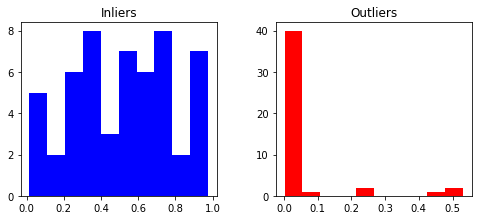

0.009727626459143969

In [30]:
from methods_cv import OneClassConformal

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, n_folds=10)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
#axs[0].set_xlim(0,1)
#axs[1].set_xlim(0,1)
plt.show()

np.median(pvals_oneclass[Y_test==1])

## Conformal p-values via binary classification (split)

In [31]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Define list of possible two-class classifiers with desired hyper-parameters
bbox_bc_list = [RandomForestClassifier(random_state=random_state),
                KNeighborsClassifier(),
                SVC(probability=True),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),
                MLPClassifier(random_state=random_state, hidden_layer_sizes=(100,100,)) 
               ]

# Choose a binary classifier algorithm
bbox_bc = bbox_bc_list[0]

Fitting the black-box model on 256 inliers and 10 outliers... done.
Calculating conformity scores for 257 hold-out inliers... done.
Calculating conformity scores for 100 test points... done.


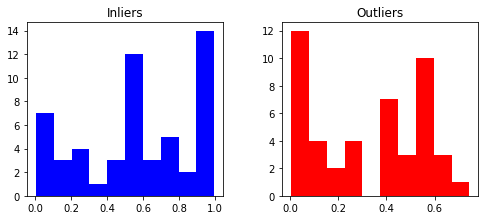

0.40891472868217055

In [32]:
from methods_split import BinaryConformal as BinaryConformal_split

# Extract the inliers from the data
X_in = X[np.where(Y==0)[0]]
X_out = X[np.where(Y==1)[0]]

# Compute the p-values
method_binary = BinaryConformal_split(X_in, X_out, bbox_bc, calib_size=0.5, random_state=2022)
pvals_binary = method_binary.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary[Y_test==0], color="blue")
axs[1].hist(pvals_binary[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
#axs[0].set_xlim(-0.1,1.01)
#axs[1].set_xlim(-0.1,1.01)
plt.show()

np.median(pvals_binary[Y_test==1])

## Conformal p-values via binary classification

Fitting the black-box model 0 on 410 inliers and 10 outliers... done.
Fitting the black-box model 1 on 410 inliers and 10 outliers... done.
Fitting the black-box model 2 on 410 inliers and 10 outliers... done.
Fitting the black-box model 3 on 411 inliers and 10 outliers... done.
Fitting the black-box model 4 on 411 inliers and 10 outliers... done.


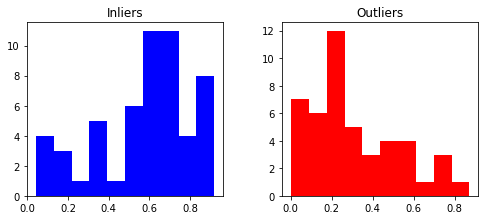

0.23443579766536965

In [33]:
from methods_cv import BinaryConformal

# Extract the inliers from the data
X_in = X[np.where(Y==0)[0]]
X_out = X[np.where(Y==1)[0]]

# Compute the p-values
method_binary = BinaryConformal(X_in, X_out, bbox_bc, n_folds=5, random_state=2022)
pvals_binary = method_binary.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary[Y_test==0], color="blue")
axs[1].hist(pvals_binary[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
#axs[0].set_xlim(-0.1,1.01)
#axs[1].set_xlim(-0.1,1.01)
plt.show()

np.median(pvals_binary[Y_test==1])

## Integrative method

Fitting a one-class classification model on 50 data points... done.
Fitting a one-class classification model on 50 data points... done.
Fitting a one-class classification model on 50 data points... done.
Fitting a one-class classification model on 50 data points... done.
Fitting a one-class classification model on 50 data points... done.
Fitting a one-class classification model on 50 data points... done.
Fitting a one-class classification model on 5 data points... done.
Fitting a one-class classification model on 5 data points... done.
Fitting a one-class classification model on 5 data points... done.
Fitting a one-class classification model on 5 data points... done.
Fitting a one-class classification model on 5 data points... done.
Fitting a one-class classification model on 5 data points... done.
Fitting a two-class classification model on 55 data points... done.
Fitting a two-class classification model on 55 data points... done.
Fitting a two-class classification model on 55 data po

/home/msesia/.local/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:284: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
/home/msesia/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
100%|██████████| 10/10 [00:00<00:00, 182.66it/s]


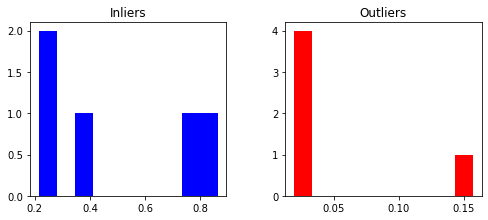

In [6]:
from methods_split import IntegrativeConformal as IntegrativeConformal_split


# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_int = IntegrativeConformal_split(X_in, X_out, bboxes_one=bbox_occ_list, bboxes_two=bboxes_two,
                                       calib_size=0.5, tuning=True)
pvals_int, pvals_int_0, pvals_int_1 = method_int.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int[Y_test==0], color="blue")
axs[1].hist(pvals_int[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Integrative method

Fitting the black-box model 0 on fold 0, which contains 8 outliers... done.
Fitting the black-box model 0 on fold 1, which contains 8 outliers... done.
Fitting the black-box model 0 on fold 2, which contains 8 outliers... done.
Fitting the black-box model 0 on fold 3, which contains 8 outliers... done.
Fitting the black-box model 0 on fold 4, which contains 8 outliers... done.
Fitting the black-box model 1 on fold 0, which contains 8 outliers... done.
Fitting the black-box model 1 on fold 1, which contains 8 outliers... done.
Fitting the black-box model 1 on fold 2, which contains 8 outliers... done.
Fitting the black-box model 1 on fold 3, which contains 8 outliers... done.
Fitting the black-box model 1 on fold 4, which contains 8 outliers... done.
Fitting the black-box model 2 on fold 0, which contains 8 outliers... done.
Fitting the black-box model 2 on fold 1, which contains 8 outliers... done.
Fitting the black-box model 2 on fold 2, which contains 8 outliers... done.
Fitting the 

/home/msesia/.local/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:284: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
/home/msesia/.local/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:284: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
/home/msesia/.local/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:284: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
/home/msesia/.local/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:284: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
/home/msesia/.local/lib/python3.8/site-packages/sklearn/neighbor

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|██        | 2/10 [00:04<00:19,  2.42s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 30%|███       | 3/10 [00:07<00:16,  2.33s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 40%|████      | 4/10 [00:09<00:13,  2.28s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 50%|█████     | 5/10 [00:11<00:11,  2.25s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 60%|██████    | 6/10 [00:13<00:08,  2.21s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best model for inliers: 3


 70%|███████   | 7/10 [00:16<00:07,  2.39s/it]

Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 80%|████████  | 8/10 [00:18<00:04,  2.35s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 90%|█████████ | 9/10 [00:20<00:02,  2.30s/it]

Best model for inliers: 3
Best model for outliers: 4


/home/msesia/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 10/10 [00:23<00:00,  2.31s/it]

Best model for inliers: 3
Best model for outliers: 4


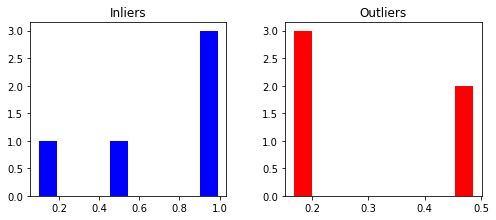

In [7]:
from methods_cv import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_int = IntegrativeConformal(X_in, X_out, bboxes_one=bbox_occ_list, bboxes_two=bboxes_two,
                                       n_folds=5, tuning=True)
pvals_int, pvals_int_0, pvals_int_1 = method_int.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int[Y_test==0], color="blue")
axs[1].hist(pvals_int[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Conformal p-values via weighted one-class classification

In [ ]:
from methods_cv import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = [bbox_occ]

# Compute the p-values
method_woc = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one, n_folds=10, tuning=True, verbose=False)
pvals_woneclass, pvals_woneclass_0, pvals_woneclass_1 = method_woc.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Plot the preliminary p-values
fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0,0].hist(pvals_woneclass_0[Y_test==0], color="blue")
axs[0,1].hist(pvals_woneclass_0[Y_test==1], color="red")  
axs[1,0].hist(pvals_woneclass_1[Y_test==0], color="red")
axs[1,1].hist(pvals_woneclass_1[Y_test==1], color="blue")  
axs[0,0].title.set_text('H0: Inliers')
axs[0,1].title.set_text('H0: Outliers')
axs[1,0].title.set_text('H1: Inliers')
axs[1,1].title.set_text('H1: Outliers')
plt.show()

np.mean(pvals_woneclass[Y_test==1])

## Integrative (one-class only) weighted ensemble

In [ ]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_woc_ens = IntegrativeConformal(X_in, X_out, 
                                           bboxes_one=bbox_occ_list, bboxes_two=[],
                                           calib_size=0.5, ratio=True, tuning=True)
pvals_woneclass_ens = method_woc_ens.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass_ens[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass_ens[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Binary ensemble (unweighted)

In [ ]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_bin_ens = IntegrativeConformal(X_in, X_out, 
                                           bboxes_two=bboxes_two,
                                           calib_size=0.5, ratio=False, tuning=True)
pvals_bin_ens = method_bin_ens.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_bin_ens[Y_test==0], color="blue")
axs[1].hist(pvals_bin_ens[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Unweighted OCC ensemble

In [ ]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

bboxes_two = bbox_occ_list

# Compute the p-values
method_unw_ens = IntegrativeConformal(X_in, X_out, 
                                           bboxes_one=bbox_occ_list, #bboxes_two=bboxes_two,
                                           calib_size=0.5, ratio=False, tuning=True)
pvals_unw_ens = method_unw_ens.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_unw_ens[Y_test==0], color="blue")
axs[1].hist(pvals_unw_ens[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Compare all p-values

In [ ]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_int[Y_test==y], U[Y_test==y], axs[y], label="Integrative", color='#9400d3',
            logarithm=logarithm)
    qq_plot(pvals_woneclass_ens[Y_test==y], U[Y_test==y], axs[y], label="Integrative (OCC)", color='#940013',
            logarithm=logarithm)
    qq_plot(pvals_unw_ens[Y_test==y], U[Y_test==y], axs[y], label="OCC (ensemble)", color='#ff1493',
            logarithm=logarithm)
    qq_plot(pvals_bin_ens[Y_test==y], U[Y_test==y], axs[y], label="Binary (ensemble)", color='#6a5acd',
            logarithm=logarithm)
    qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary (single)", color="#6495ED",
            logarithm=logarithm)
    qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="OCC (single)", color='#FFA500',
            logarithm=logarithm)

plt.legend(loc=(1,0.5))
plt.show()


fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_int[Y_test==y], U[Y_test==y], axs[y], label="Integrative", color='#9400d3',
            logarithm=logarithm)
    qq_plot(pvals_woneclass_ens[Y_test==y], U[Y_test==y], axs[y], label="Integrative (OCC)", color='#940013',
            logarithm=logarithm)
    qq_plot(pvals_unw_ens[Y_test==y], U[Y_test==y], axs[y], label="OCC (ensemble)", color='#ff1493',
            logarithm=logarithm)
    qq_plot(pvals_bin_ens[Y_test==y], U[Y_test==y], axs[y], label="Binary (ensemble)", color='#6a5acd',
            logarithm=logarithm)
    qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary (MLP)", color="#6495ED",
            logarithm=logarithm)
    qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="OCC (IF)", color='#FFA500',
            logarithm=logarithm)

plt.xlim(0, 0.3)
plt.ylim(0, 0.05)
plt.legend(loc=(1,0.5))
plt.show()